In [1]:
from fastai.vision.all import *
import wandb
import seaborn as sns
api = wandb.Api()
matplotlib.rcParams['font.size']

10.0

In [6]:
art_m = wandb.Artifact('model','model')

In [8]:
art_m.add_file('plots.ipynb',)

<ManifestEntry digest: X3V4iqsiuPZV5eqCM6b4aA==>

In [10]:
art_m.save('exps')

wandb: Currently logged in as: erow (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.7 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [15]:
matplotlib.rcParams['font.size'] = 12

In [2]:
runs = api.runs('erow/DistillationVAE',{'tags':'NMI'})
len(runs)

21

In [14]:
data = []
for r in runs:
    his = r.history(keys=['discrete_mi'])
    nmis = his['discrete_mi'].values.tolist() / np.log([[[3,6,40,32,32]]])
    nmis.sort(1)
    m_name = r.config['model.regularizers'][0].split('.')[-1]
    for step,nmi in zip(his['_step'],nmis):
        data.append({'model':m_name,'step':step, 'nmi1':nmi[-1].mean(),'nmi2':nmi[-2].mean()})
    # pd.concat([mig,pd.DataFrame({'model':['c']*len(mig)})],1)
    
df = pd.DataFrame(data)
df.tail()

,model,step,nmi1,nmi2
283,CascadeVAEC,40201,0.309563,0.109731
284,CascadeVAEC,50100,0.311221,0.073849
285,CascadeVAEC,50201,0.314811,0.120628
286,CascadeVAEC,60100,0.304235,0.090556
287,CascadeVAEC,60201,0.303838,0.105095


In [17]:
runs = api.runs('erow/DistillationVAE',{'tags':'reproduce'})
len(runs)

16

In [18]:
for r in runs:
    his = r.history(keys=['discrete_mi'])
    nmis = his['discrete_mi'].values.tolist() / np.log([[[3,6,40,32,32]]])
    nmis.sort(1)
    m_name = r.config['model.regularizers'][0].split('.')[-1]
    for step,nmi in zip(his['_step'],nmis):
        data.append({'model':m_name,'step':step, 'nmi1':nmi[-1].mean(),'nmi2':nmi[-2].mean()})

df = pd.DataFrame(data)
df.tail()

,model,step,nmi1,nmi2
679,DEFT,45102,0.437299,0.164068
680,DEFT,40,0.176885,0.015918
681,DEFT,81,0.225912,0.017536
682,DEFT,200,0.243726,0.023358
683,DEFT,200,0.240878,0.025051


In [22]:
df.to_csv('NMI_dsprites.csv')

In [6]:
df = pd.read_csv('NMI_dsprites.csv')
nmi1=df[df['model']=='CascadeVAEC']['nmi1']
df['nmi1'][df['model']=='CascadeVAEC'] = nmi1 + 0.1

ipykernel_launcher:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


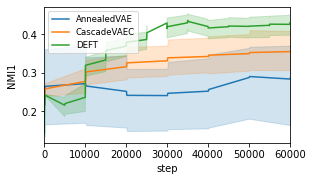

In [7]:
# 监测IB approaches在训练过程中NMI的变化情况。
# df = pd.read_csv('NMI_dsprites.csv')
fig, axes = plt.subplots(1,1,figsize=(4.4,2.5))
sns.lineplot(data=df,x='step',y='nmi1',hue='model',ax=axes)
# axes.set_xlim(0,60000)
# sns.lineplot(data=df,x='step',y='nmi2',hue='model',ax=axes[1])
plt.legend(prop={'size': 8.5},loc=2)
plt.xlim(0,60000)
plt.ylabel('NMI1')
plt.savefig('pics/NMI1.pdf',bbox_inches='tight',pad_inches=0.0)

In [8]:
runs = api.runs('erow/disentanglement_lib-exps',{'tags':'reproduce'})

data=[]
for r in runs:
    gamma=r.config['frac_encoder.gamma']
    his = r.history(keys=['discrete_mi'])
    if len(his)<10 :
        continue
    nmis = his['discrete_mi'].values.tolist() / np.log([[[3,6,40,32,32]]])
    nmis.sort(1)
    m_name = r.config['model.regularizers'][0].split('.')[-1]
    for step,nmi in zip(his['_step'],nmis):
        data.append({'gamma':gamma,'step':step, 'nmi1':nmi[-1].mean(),'nmi2':nmi[-2].mean()})

df = pd.DataFrame(data)
df.tail()

,gamma,step,nmi1,nmi2
555,0.1,55101,0.401912,0.071746
556,0.1,60050,0.401462,0.073978
557,0.1,60101,0.404811,0.071540
558,0.1,65050,0.405388,0.074685
559,0.1,65101,0.402131,0.124585


(0.12156862745098039, 0.4666666666666667, 0.7058823529411765)

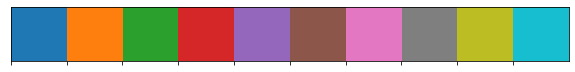

In [9]:
current_palette = sns.color_palette()
sns.palplot(current_palette)
current_palette[0]

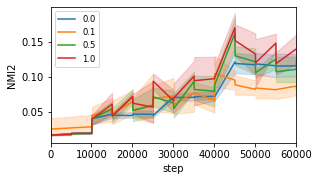

In [10]:
fig, axes = plt.subplots(1,1,figsize=(4.4,2.5))
sns.lineplot(data=df,x='step',y='nmi2',hue='gamma',palette=current_palette[:4])
plt.legend(prop={'size': 8.5})
plt.ylabel('NMI2')
plt.xlim(0,60000)
plt.savefig('pics/gamma.pdf',bbox_inches='tight',pad_inches=0.0)

In [21]:
from collections import defaultdict
runs = api.runs('erow/DistillationVAE',{'tags':'stage2'})
len(runs)

18

In [22]:
res = defaultdict(list)
for r in runs:
    k = 'frac_encoder.gamma'
    if k in r.config and r.config[k] == 0.1:
        mi = r.summary['discrete_mi']
        mi = np.array(mi)
        nmi = mi / np.log([[3,6,40,32,32]])
        nmi.sort(0)
        res[r.config['deft1.beta']].append(nmi[-2::]) 
res

defaultdict(list,
            {1: [array([[0.16384306, 0.1785954 , 0.0162651 , 0.09233248, 0.12407177],
                     [0.44601722, 0.46881293, 0.16265102, 0.58573419, 0.57419263]])],
             10: [array([[0.07281914, 0.20650093, 0.0108434 , 0.07213475, 0.10098865],
                     [0.28217416, 0.55811063, 0.01355425, 0.62035887, 0.61458809]])],
             30: [array([[0.08192153, 0.35160969, 0.0108434 , 0.10098865, 0.0865617 ],
                     [0.25486698, 0.56369173, 0.0108434 , 0.62612965, 0.62612965]])]})

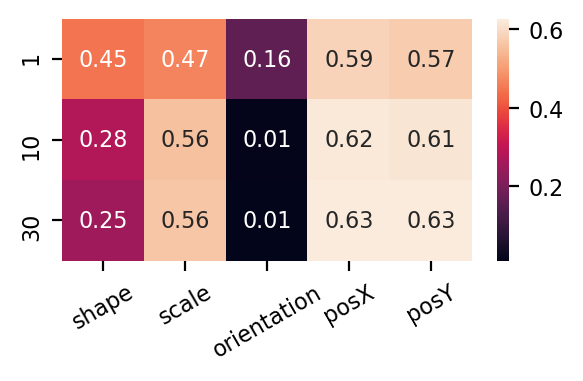

In [33]:
plt.subplots(figsize=(3.3,1.6),dpi=200)
matplotlib.rcParams.update({'font.size':8})
g=sns.heatmap([nmi[0][1] for beta,nmi in res.items()],
        yticklabels=[beta for beta,nmi in res.items()],
        annot=True,fmt='.2f')
g.set_xticklabels(['shape','scale','orientation','posX','posY'],rotation=30)
plt.savefig('pics/beta_NMI1.pdf',bbox_inches='tight',pad_inches=0.0)

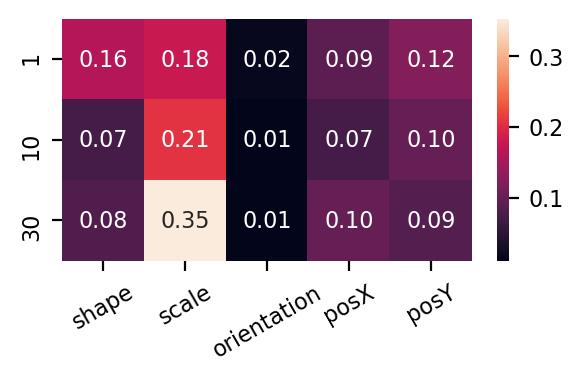

In [34]:
plt.subplots(figsize=(3.3,1.6),dpi=200)
g=sns.heatmap([nmi[0][0] for beta,nmi in res.items()],
        yticklabels=[beta for beta,nmi in res.items()],
        annot=True,fmt='.2f')
g.set_xticklabels(['shape','scale','orientation','posX','posY'],rotation=30)
plt.savefig('pics/beta_NMI2.pdf',bbox_inches='tight',pad_inches=0.0)

In [37]:
res = defaultdict(list)
for r in runs:
    k = 'deft1.beta'
    if k in r.config and r.config[k] == 30:
        mi = r.summary['discrete_mi']
        mi = np.array(mi)
        nmi = mi / np.log([[3,6,40,32,32]])
        nmi.sort(0)
        res[r.config['frac_encoder.gamma']].append(nmi[-2::]) 
res

defaultdict(list,
            {0.1: [array([[0.08192153, 0.35160969, 0.0108434 , 0.10098865, 0.0865617 ],
                     [0.25486698, 0.56369173, 0.0108434 , 0.62612965, 0.62612965]])],
             0.3: [array([[0.08192153, 0.40183965, 0.0108434 , 0.17600879, 0.11830099],
                     [0.24576459, 0.55811063, 0.0108434 , 0.62901504, 0.62612965]])],
             0.5: [array([[0.05461435, 0.1785954 , 0.0108434 , 0.0865617 , 0.12118638],
                     [0.2366622 , 0.55811063, 0.0108434 , 0.62612965, 0.62324426]])],
             0.7: [array([[0.05461435, 0.29021753, 0.0108434 , 0.11830099, 0.07502014],
                     [0.2366622 , 0.55811063, 0.0108434 , 0.62901504, 0.62612965]])],
             1: [array([[0.10012631, 0.37393412, 0.0108434 , 0.09521787, 0.10964482],
                     [0.2366622 , 0.55252952, 0.0108434 , 0.61747348, 0.62324426]])],
             0: [array([[0.04551196, 0.16185208, 0.0108434 , 0.13849872, 0.11253021],
                     [0.1092

[Text(0.5, 0, 'shape'),
 Text(1.5, 0, 'scale'),
 Text(2.5, 0, 'orientation'),
 Text(3.5, 0, 'posX'),
 Text(4.5, 0, 'posY')]

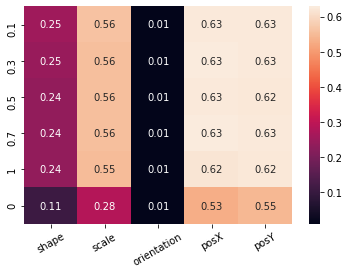

In [40]:
g=sns.heatmap([nmi[0][0] for beta,nmi in res.items()],
        yticklabels=[beta for beta,nmi in res.items()],
        annot=True,fmt='.2f')
g.set_xticklabels(['shape','scale','orientation','posX','posY'],rotation=30)

Text(0.5, 1.0, 'NMI2 [70, 30]')

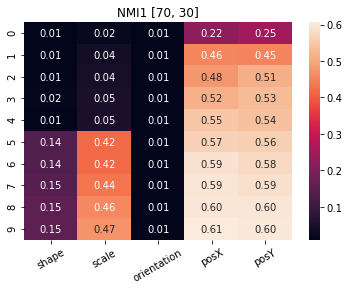

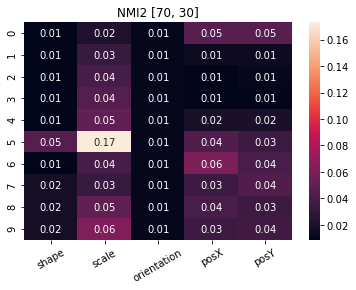

In [4]:
r = api.run('erow/DistillationVAE/2muao2n8')
mi = np.array(r.history(keys=['discrete_mi'])['discrete_mi'].tolist())
nmi  = mi / np.log([[[3,6,40,32,32]]])
nmi.sort(1)

data =  nmi[:,-1]
g=sns.heatmap(data[4::5,],
            # yticklabels=data[:,0],
            annot=True,fmt='.2f')
g.set_xticklabels(['shape','scale','orientation','posX','posY'],rotation=30)
plt.title('NMI1 '+str(r.config['deft.betas']))

plt.figure()
data =  nmi[:,-2]
g=sns.heatmap(data[4::5,],
            # yticklabels=data[:,0],
            annot=True,fmt='.2f')
g.set_xticklabels(['shape','scale','orientation','posX','posY'],rotation=30)
plt.title('NMI2 '+str(r.config['deft.betas']))

In [4]:
mi.shape

(5, 4, 5)

[Text(0.5, 0, 'shape'),
 Text(1.5, 0, 'scale'),
 Text(2.5, 0, 'orientation'),
 Text(3.5, 0, 'posX'),
 Text(4.5, 0, 'posY')]

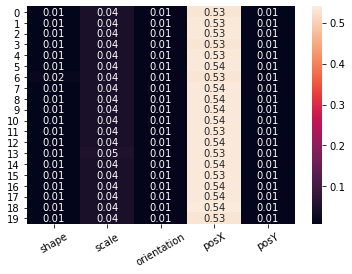

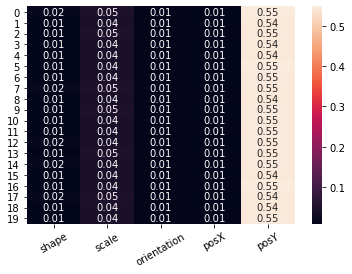

In [14]:
r = api.run('erow/DistillationVAE/xr4n9u2n')
mi = np.array(r.history(keys=['discrete_mi'])['discrete_mi'].tolist())
nmi  = mi / np.log([[[3,6,40,32,32]]])
# nmi.sort(1)

data =  nmi[:,2]
g=sns.heatmap(data[:,],
            # yticklabels=data[:,0],
            annot=True,fmt='.2f')
g.set_xticklabels(['shape','scale','orientation','posX','posY'],rotation=30)
# plt.title('NMI1 '+str(r.config['deft.betas']))

plt.figure()
data =  nmi[:,1]
g=sns.heatmap(data[:,],
            # yticklabels=data[:,0],
            annot=True,fmt='.2f')
g.set_xticklabels(['shape','scale','orientation','posX','posY'],rotation=30)
# plt.title('NMI2 '+str(r.config['deft.betas']))

In [39]:
((nmi[:,-1]-nmi[:,-2])[-1])

array([0.29127655, 0.30696084, 0.11656656, 0.51359943, 0.50494326])

In [46]:
r = api.run('erow/DistillationVAE/1y5ccqek')
mi = np.array(r.history(keys=['discrete_mi'])['discrete_mi'].tolist())
nmi  = mi / np.log([[[3,6,40,32,32]]])
nmi.sort(1)

data =  nmi[:,-1]
g=sns.heatmap(data[4::5,],
            # yticklabels=data[:,0],
            annot=True,fmt='.2f')
g.set_xticklabels(['shape','scale','orientation','posX','posY'],rotation=30)
plt.title('NMI1 '+str(r.config['deft.betas']))

plt.figure()
data =  nmi[:,-2]
g=sns.heatmap(data[4::5,],
            # yticklabels=data[:,0],
            annot=True,fmt='.2f')
g.set_xticklabels(['shape','scale','orientation','posX','posY'],rotation=30)
plt.title('NMI2 '+str(r.config['deft.betas']))

(array([0.02730718, 0.02730718, 0.01820478, 0.00910239, 0.00910239,
        0.00910239, 0.00910239, 0.00910239, 0.00910239, 0.00910239,
        0.00910239, 0.00910239, 0.00910239, 0.00910239, 0.00910239,
        0.00910239, 0.00910239, 0.00910239, 0.00910239, 0.00910239,
        0.00910239, 0.00910239, 0.00910239, 0.00910239, 0.00910239,
        0.02730718, 0.01820478, 0.00910239, 0.01820478, 0.00910239,
        0.02730718, 0.01820478, 0.00910239, 0.00910239, 0.00910239,
        0.01820478, 0.00910239, 0.00910239, 0.00910239, 0.03640957,
        0.00910239, 0.00910239, 0.00910239, 0.00910239, 0.01820478,
        0.02730718, 0.10012631, 0.10922871, 0.10012631, 0.10922871]),
 array([0.00910239, 0.00910239, 0.00910239, 0.00910239, 0.00910239,
        0.00910239, 0.00910239, 0.03640957, 0.01820478, 0.10922871]))

In [4]:
torch.rand(2,3).tolist()

[[0.29307615756988525, 0.36449992656707764, 0.5138415098190308],
 [0.5433683395385742, 0.4379439353942871, 0.9571142196655273]]

In [11]:
from disentanglement_lib.methods.unsupervised import train
from disentanglement_lib.methods.shared import architectures

In [12]:
def count_parameters(model):
    pytorch_total_params = sum(p.numel() for p in model.parameters())
    return pytorch_total_params

In [61]:
num_latent = 1000
encoder = architectures.conv_encoder([1,64,64],num_latent,base_channel=771).cuda()
encoder1 = architectures.FracEncoder([1,64,64],num_latent,G=1000).cuda()

In [15]:
for G in Gs:
    num_latent = 1000
    encoder = architectures.conv_encoder([1,64,64],num_latent,base_channel=channel_g[G])
    encoder1 = architectures.FracEncoder([1,64,64],num_latent,G=G)
    print(count_parameters(encoder1)/count_parameters(encoder))

1.0030692420672613
0.9996734791764257
1.0084851236255483
1.0110388140947149
1.017047022940375
1.0009065833381556
1.0036028759118425
1.0


In [62]:
count_parameters(encoder1)/count_parameters(encoder)

1.0030692420672613

In [4]:
import timeit

In [21]:
def time_consumption(f,num):
    for _ in range(num):
        cur = time.time()
        f()
        interval = time.time() - cur
        yield interval

In [25]:
data = []
number = 100

def compute(model):
    def _f():
        x = torch.randn(256,1,64,64).cuda()
        mu, logvar = model(x)
        loss = (mu**2+logvar.exp()-logvar).mean()
        loss.backward()
    return _f
Gs = [1000, 500,200, 100, 50, 10, 5, 1]
channel_g={1000: 771, 500: 536, 200: 325, 100: 220, 50: 146, 10: 52, 5: 31, 1: 8}
for G in Gs:
    num_latent = 1000
    encoder = architectures.conv_encoder([1,64,64],num_latent,base_channel=channel_g[G]).cuda()
    c=time_consumption(compute(encoder),number)
    encoder1 = architectures.FracEncoder([1,64,64],num_latent,G=G).cuda()
    c1 = time_consumption(compute(encoder1),number)
    data.append({'c':list(c),'c1':list(c1),'G':G,'p':count_parameters(encoder)})


In [26]:
df = pd.DataFrame(data)
df

,c,c1,G,p
0,"[0.05636191368103027, 0.6487514972686768, 0.615128755569458, 0.6153626441955566, 0.6187918186187744, 0.6183953285217285, 0.6165485382080078, 0.6191456317901611, 0.6164863109588623, 0.6198029518127441, 0.6182034015655518, 0.6186583042144775, 0.6184391975402832, 0.616185188293457, 0.6210982799530029, 0.6198248863220215, 0.6176338195800781, 0.6194412708282471, 0.621025800704956, 0.619476318359375, 0.6203324794769287, 0.621830940246582, 0.6223983764648438, 0.6202793121337891, 0.6237928867340088, 0.621354341506958, 0.6239869594573975, 0.6240942478179932, 0.6241371631622314, 0.6210522651672363, ...","[0.8204729557037354, 0.2170557975769043, 0.2604789733886719, 0.24834012985229492, 0.23830223083496094, 0.2291882038116455, 0.21381735801696777, 0.23902344703674316, 0.5080611705780029, 0.20238399505615234, 0.19365954399108887, 0.2043144702911377, 0.20542144775390625, 0.21067261695861816, 0.20060372352600098, 0.2026665210723877, 0.20188570022583008, 0.20614361763000488, 0.21060800552368164, 0.20269989967346191, 0.20272564888000488, 0.1995091438293457, 0.2070605754852295, 0.2098069190979004, 0.19614267349243164, 0.20200181007385254, 0.20085525512695312, 0.20897388458251953, 0.210593461990356...",1000,73424642
1,"[0.05618858337402344, 0.34327268600463867, 0.31057238578796387, 0.312131404876709, 0.31878232955932617, 0.3152158260345459, 0.3113243579864502, 0.3159644603729248, 0.3141756057739258, 0.31222105026245117, 0.3163411617279053, 0.31349658966064453, 0.3142421245574951, 0.31442737579345703, 0.31510353088378906, 0.31149983406066895, 0.31563568115234375, 0.3120286464691162, 0.31574296951293945, 0.3166468143463135, 0.31383776664733887, 0.31243371963500977, 0.3156769275665283, 0.31632304191589355, 0.3152961730957031, 0.3124043941497803, 0.3175017833709717, 0.31531786918640137, 0.312727689743042, 0....","[0.3978855609893799, 0.11989259719848633, 0.12117695808410645, 0.11435866355895996, 0.10961508750915527, 0.1164102554321289, 0.11049866676330566, 0.11272621154785156, 0.11373710632324219, 0.1190035343170166, 0.11835336685180664, 0.12049579620361328, 0.11352229118347168, 0.11232900619506836, 0.1145179271697998, 0.11491155624389648, 0.11366653442382812, 0.11467981338500977, 0.12010025978088379, 0.11828279495239258, 0.14852619171142578, 0.1264803409576416, 0.1102449893951416, 0.1099092960357666, 0.11308789253234863, 0.11363816261291504, 0.11557555198669434, 0.1192631721496582, 0.1141996383666...",500,37094112
2,"[0.04686474800109863, 0.15020513534545898, 0.13120579719543457, 0.12531542778015137, 0.1289806365966797, 0.12661075592041016, 0.12586259841918945, 0.12633156776428223, 0.1266024112701416, 0.12607526779174805, 0.12374138832092285, 0.12653160095214844, 0.12838292121887207, 0.12630200386047363, 0.12588810920715332, 0.1268322467803955, 0.12490558624267578, 0.1271805763244629, 0.12475109100341797, 0.12603139877319336, 0.12978434562683105, 0.12378501892089844, 0.12729692459106445, 0.12659168243408203, 0.12646794319152832, 0.1256108283996582, 0.12517023086547852, 0.12615346908569336, 0.1282172203...","[0.15474843978881836, 0.06868147850036621, 0.0690298080444336, 0.0683431625366211, 0.07033419609069824, 0.06937837600708008, 0.06949257850646973, 0.06737661361694336, 0.06933069229125977, 0.07160520553588867, 0.06973600387573242, 0.06923460960388184, 0.0672149658203125, 0.0698704719543457, 0.06998753547668457, 0.07013368606567383, 0.06984210014343262, 0.06926560401916504, 0.06920886039733887, 0.0694429874420166, 0.06934833526611328, 0.0695943832397461, 0.06911563873291016, 0.07064175605773926, 0.07145166397094727, 0.07075810432434082, 0.07016611099243164, 0.07028436660766602, 0.06758069992...",200,15013806
3,"[0.046480655670166016, 0.07336902618408203, 0.07130122184753418, 0.07347345352172852, 0.06931495666503906, 0.06351041793823242, 0.06134295463562012, 0.0628652572631836, 0.06263875961303711, 0.06196475028991699, 0.06189870834350586, 0.06122183799743652, 0.06274247169494629, 0.062212228775024414, 0.06261014938354492, 0.0617482662

In [43]:
def T(x):
    if not isinstance(x, list):
        return x
    else:
        m =(np.mean(x)).round(3)
        std = np.std(x).round(3)
        return f"{m} pm {std}"
df1=df.applymap(T)
df1.index = df1['G']
df1

,c,c1,G,p
G,,,,
1000,0.622 pm 0.057,0.225 pm 0.069,1000,73424642
500,0.314 pm 0.026,0.121 pm 0.034,500,37094112
200,0.126 pm 0.008,0.07 pm 0.009,200,15013806
100,0.062 pm 0.003,0.058 pm 0.004,100,7742136
50,0.044 pm 0.003,0.05 pm 0.004,50,4100892
10,0.044 pm 0.002,0.046 pm 0.004,10,1244232
5,0.046 pm 0.003,0.046 pm 0.004,5,876522
1,0.044 pm 0.002,0.046 pm 0.004,1,587136


In [44]:
df2 = df1[['c','c1']]
df2 = df2.sort_index()
df2.T

G,1,5,10,50,100,200,500,1000
c,0.044 pm 0.002,0.046 pm 0.003,0.044 pm 0.002,0.044 pm 0.003,0.062 pm 0.003,0.126 pm 0.008,0.314 pm 0.026,0.622 pm 0.057
c1,0.046 pm 0.004,0.046 pm 0.004,0.046 pm 0.004,0.05 pm 0.004,0.058 pm 0.004,0.07 pm 0.009,0.121 pm 0.034,0.225 pm 0.069


In [46]:
print(df2.T[[1,10,100,500,1000]].to_latex())

\begin{tabular}{llllll}
\toprule
G &            1    &            10   &            100  &            500  &            1000 \\
\midrule
c  &  0.044 pm 0.002 &  0.044 pm 0.002 &  0.062 pm 0.003 &  0.314 pm 0.026 &  0.622 pm 0.057 \\
c1 &  0.046 pm 0.004 &  0.046 pm 0.004 &  0.058 pm 0.004 &  0.121 pm 0.034 &  0.225 pm 0.069 \\
\bottomrule
\end{tabular}



In [47]:
0.062/0.058-1

0.06896551724137923

In [33]:
channel_g ={}
for G in Gs:
    encoder1 = architectures.FracEncoder([1,64,64],num_latent,G=G)
    c1 = count_parameters(encoder1)
    l=1
    r=1000
    while l<r:
        m = (l+r)//2
        encoder = architectures.conv_encoder([1,64,64],num_latent,base_channel=m)
        c=count_parameters(encoder) 
        if c>c1:
            r = m - 1
        else:
            l = m + 1
    print(G,c1/c,m)
    channel_g[G]=m
channel_g

1000 1.0030692420672613 771
500 0.9996734791764257 536
200 1.0084851236255483 325
100 1.0110388140947149 220
50 1.017047022940375 146
10 1.0009065833381556 52
5 0.9864183576439349 32
1 0.9830591339698018 9


{1000: 771, 500: 536, 200: 325, 100: 220, 50: 146, 10: 52, 5: 32, 1: 9}

In [80]:
mi =np.array([[0.011233547490071952,0.007453225228425795,0.04147532997348251,0.031244424976091943,2.057718763305422],[0.012553540394035133,0.006075527958290156,0.04362217270537166,2.074707289342484,0.02851974996125592],[0.2718984420048221,0.9061823223298088,0.044158098625904606,0.04350861325311293,0.05097894882637976],[0.47132737198126967,1.1653236985877435,0.038250131588865185,0.03286452158718252,0.04641063727218073],[0.022176262581171637,0.08172304953047423,0.09320876517475468,0.03674286831965088,0.051041193150469504],[0.34769865384149934,0.10646391192833266,0.8210018323421249,0.029866972607043796,0.03500480961845455],[0.3379369704781243,0.09789952637737644,0.8823960125329007,0.03309660727353081,0.033204770730138576],[0.1017236425968929,0.031580279379056206,0.2608307705695827,0.04493749676112093,0.06391285801706327],[0.007579086695671879,0.03641147094619829,0.03300022323143218,0.09323950889786169,0.11228169446200575],[0.011010312534271595,0.09029262196945768,0.03724575059057264,0.3045435387079504,0.0920201000821084]])
nmi = mi / np.log([[3,6,40,32,32]])
nmi.sort(0)
mi.round(2)

array([[0.01, 0.01, 0.04, 0.03, 2.06],
       [0.01, 0.01, 0.04, 2.07, 0.03],
       [0.27, 0.91, 0.04, 0.04, 0.05],
       [0.47, 1.17, 0.04, 0.03, 0.05],
       [0.02, 0.08, 0.09, 0.04, 0.05],
       [0.35, 0.11, 0.82, 0.03, 0.04],
       [0.34, 0.1 , 0.88, 0.03, 0.03],
       [0.1 , 0.03, 0.26, 0.04, 0.06],
       [0.01, 0.04, 0.03, 0.09, 0.11],
       [0.01, 0.09, 0.04, 0.3 , 0.09]])

In [75]:
(nmi[-1]-nmi[-2])

array([0.11253171, 0.14462956, 0.01664304, 0.51076129, 0.56133448])

In [78]:
mi = [[0.012424367718864652,0.00961345825891161,0.04741654034433235,2.08384172286244,0.027578047798544107],[0.010259011510265013,0.007001150778571019,0.04545321061708443,0.031032114933039964,2.1177346840223312],[0.44717783545543954,1.149874654501385,0.04260910427988428,0.07414043510344122,0.042006827018749776],[0.05454814318055117,0.1726339781022088,0.03266414998256009,0.06373791266193052,0.07084144111695184],[0.34915596992712017,0.052359956941787154,0.7915556217283768,0.037102036922413525,0.03408559140049079],[0.33262728006742814,0.03781120451414864,0.47474298986751007,0.04323025432879161,0.031252703850764584],[0,1.3877787807814457e-15,7.632783294297951e-16,7.494005416219809e-16,6.38378239159465e-16],[0,1.3877787807814457e-15,7.632783294297951e-16,7.494005416219809e-16,6.38378239159465e-16],[0.006794411035648281,0.04049652450836264,0.0372681786238521,0.16620065460570974,0.06869405176392633],[0.014098050156851004,0.05196233550259384,0.03672055214588403,0.11017220496294929,0.116292017522721]]
nmi = mi / np.log([[3,6,40,32,32]])
nmi.sort(0)
(nmi[-1]-nmi[-2])

array([0.08922335, 0.54540841, 0.08588316, 0.55331425, 0.57749428])

In [1]:
api

NameError: name 'api' is not defined

In [3]:
runs = api.runs('erow/dlib',{'tags':'fluctuation', 'config.dataset':'dsprites_full'})
len(runs)

9

In [11]:
data = []
for r in runs:
    his = r.history(keys=['discrete_mi'])
    for row in his.values:
        step, mi =row
        nmi = mi/np.log([[3,6,40,32,32]])
        nmi.sort(0)
        data.append({
            'model':r.config['model'],
            'step': step,
            'nmi1': nmi[-1].mean(),
            'nmi2': nmi[-2].mean(),
        })
df = pd.DataFrame(data)
df

,model,step,nmi1,nmi2
0,BetaTCVAE,6949,0.337102,0.076258
1,BetaTCVAE,13949,0.423057,0.159362
2,BetaTCVAE,20949,0.447897,0.131802
3,BetaTCVAE,27949,0.446362,0.155786
4,BetaTCVAE,34949,0.456709,0.141721
...,...,...,...,...
94,CascadeVAEC,48949,0.367857,0.118412
95,CascadeVAEC,55949,0.373140,0.121129
96,CascadeVAEC,62949,0.374747,0.132497
97,CascadeVAEC,69949,0.381112,0.134643


<AxesSubplot:xlabel='step', ylabel='nmi1'>

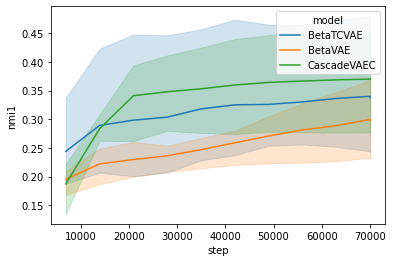

In [17]:
sns.lineplot(data=df,x='step',y='nmi1', hue ='model')

<AxesSubplot:xlabel='step', ylabel='nmi2'>

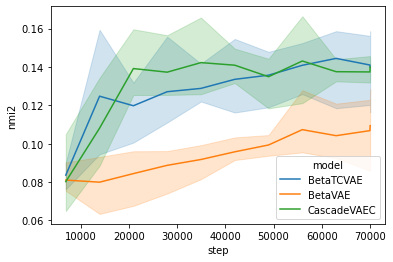

In [18]:
sns.lineplot(data=df,x='step',y='nmi2', hue ='model')

In [149]:
gamma_data={1: [[0.01, 0.06, 0.03, 0.32, 0.09],
  [0, 0.02, 0.04, 0.04, 1.99],
  [0, 0.02, 0.04, 2.03, 0.03],
  [0.01, 0.06, 0.04, 0.1, 0.43],
  [0.01, 0.04, 0.03, 0.19, 0.21],
  [0.18, 0.84, 0.06, 0.06, 0.06],
  [0.04, 0.32, 0.04, 0.05, 0.11],
  [0.49, 0.06, 0.6, 0.05, 0.05],
  [0.06, 0.08, 0.05, 0.06, 0.11],
  [0.02, 0.05, 0.05, 0.04, 0.15]],
 10: [[0.02, 0.12, 0.04, 0.25, 0.21],
  [0, 0.01, 0.04, 0.03, 2.13],
  [0.01, 0.02, 0.04, 2.15, 0.03],
  [0, 0.06, 0.04, 0.14, 0.35],
  [0.03, 0.13, 0.04, 0.15, 0.13],
  [0.02, 0.16, 0.03, 0.07, 0.14],
  [0.05, 0.37, 0.05, 0.08, 0.14],
  [0.31, 1, 0.04, 0.08, 0.09],
  [0.08, 0.26, 0.04, 0.13, 0.1],
  [0.04, 0.17, 0.03, 0.1, 0.13]],
 30: [[0.01, 0.03, 0.04, 0.3, 0.3],
  [0.01, 0.02, 0.04, 0.03, 2.17],
  [0.01, 0.02, 0.04, 2.17, 0.04],
  [0.03, 0.22, 0.04, 0.19, 0.2],
  [0.01, 0.08, 0.04, 0.35, 0.29],
  [0.09, 0.63, 0.04, 0.09, 0.19],
  [0.09, 0.4, 0.04, 0.11, 0.19],
  [0.09, 0.57, 0.04, 0.1, 0.09],
  [0.28, 1.01, 0.04, 0.1, 0.09],
  [0.01, 0.21, 0.04, 0.13, 0.14]]}

In [151]:
data =[]
for k,mi in gamma_data.items():
    nmi = mi/np.log([[3,6,40,32,32]])
    nmi.sort(0)
    nmi=nmi.round(3)
    data.append({'gamma':k,'NMI1':nmi[-1],'NMI2':nmi[-2]}
    )
df=pd.DataFrame(data)
df

,gamma,NMI1,NMI2
0,1,"[0.446, 0.469, 0.163, 0.586, 0.574]","[0.164, 0.179, 0.016, 0.092, 0.124]"
1,10,"[0.282, 0.558, 0.014, 0.62, 0.615]","[0.073, 0.207, 0.011, 0.072, 0.101]"
2,30,"[0.255, 0.564, 0.011, 0.626, 0.626]","[0.082, 0.352, 0.011, 0.101, 0.087]"


Text(23.944444444444446, 0.5, '$\\beta$')

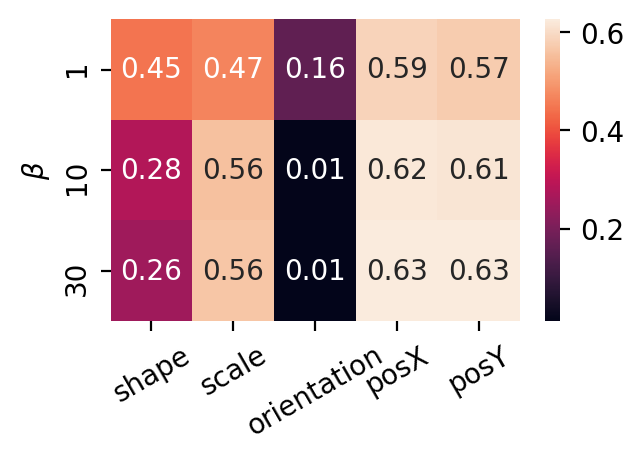

In [161]:
plt.subplots(figsize=(3.3,2),dpi=200)
g=sns.heatmap(df['NMI1'].values.tolist(),
            yticklabels=df['gamma'],
            annot=True,fmt='.2f')

g.set_xticklabels(['shape','scale','orientation','posX','posY'],rotation=30)
plt.ylabel('$\\beta$')

Text(23.944444444444446, 0.5, '$\\beta$')

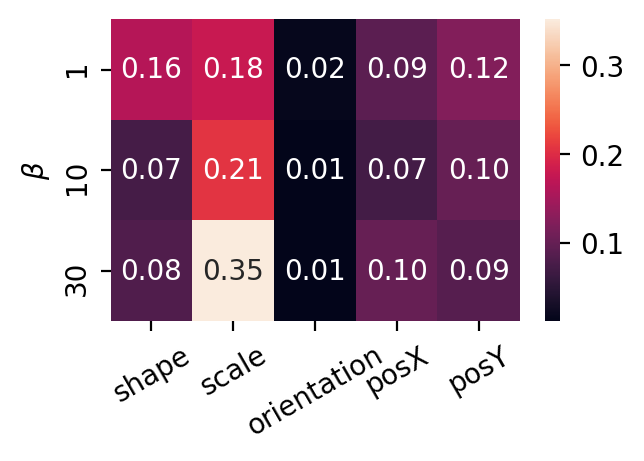

In [162]:
plt.subplots(figsize=(3.3,2),dpi=200)
g=sns.heatmap(df['NMI2'].values.tolist(),
            yticklabels=df['gamma'],
            annot=True,fmt='.2f')

g.set_xticklabels(['shape','scale','orientation','posX','posY'],rotation=30)
plt.ylabel('$\\beta$')